In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
class MultiVarLinearRegression:
    def __init__(self, df: pd.DataFrame, targets: list[str]):
        self.data = df
        self.targets = targets
        self.tsize = len(targets)
        self.xsize = df.shape[0]
        self.ysize = df.shape[1] - self.tsize

        all_column_names = list(df.columns)
        for target in targets:
            all_column_names.remove(target)

        self.variables = ['bias'] + all_column_names
    
    def setup(self):
        self.index = self.data.index.to_numpy()
        self.X = np.ones([self.xsize,self.ysize+1])
        self.X[:,1:] = self.data.iloc[:,:-self.tsize].to_numpy()
        self.XT = self.X.T
        self.Y = self.data.iloc[:,-self.tsize:].to_numpy()
    
    def solve(self):
        self.B = np.linalg.solve(self.XT.dot(self.X),self.XT.dot(self.Y))
        betaDF = pd.DataFrame()
        for i in range(len(self.B)):
            betaDF[self.variables[i]] = [self.B[i]]
        return betaDF
    
    def plot_compare(self, Y0, Y, R2, var_name, title, plot=True):
        if plot:
            plt.figure(figsize=(20,6))
            plt.plot(Y0,'-',label='dados')
            plt.plot(Y,'-',label='prediçao')
            plt.title(title + ' - R2: ' + str(np.round(R2, 4)))
            plt.ylabel(var_name)
            plt.xlabel('Medições')
            plt.legend()
            plt.show()

        return Y, Y0

    def plot_error(self, Y0, Y, var_name, title, plot=True):
        Yerror = Y - Y0
        if plot:
            plt.figure(figsize=(20,6))
            plt.plot(Yerror,'-',label=var_name)
            plt.title(title + ' - Erro')
            plt.ylabel('Erro absoluto')
            plt.xlabel('Medições')
            plt.legend()
            plt.show()

        return Yerror

    def predict(self, Xpred):
        prediction = Xpred.dot(self.B)
        predictionDF = pd.DataFrame(prediction, columns=self.targets)
        return predictionDF

    def plot_train_results(self, title='Dados x Predição', zoom=1.0, plot=True):
        zoom_init = int(self.Y.shape[0]*(1-zoom))
        Xzoom = self.X[zoom_init:]
        Yzoom = self.Y[zoom_init:]
        index_zoom = self.index[zoom_init:]
        y = self.predict(Xzoom).to_numpy()
        i = 0
        returnDict = {}
        for target_name in self.targets:
            ym = self.Y[:,i].mean()
            R2 = 1 - np.sum((Yzoom[:,i]-y[:,i])**2)/np.sum((Yzoom[:,i]-ym)**2)
            yplot, ydata = self.plot_compare(Yzoom[:,i], y[:,i], R2, target_name, title, plot)
            yerror = self.plot_error(Yzoom[:,i], y[:,i],target_name,title, plot)
            i += 1
            returnDict[target_name] = {'R2': R2, 'Y': yplot, 'Y0': ydata, 'error': yerror, 'index': index_zoom}

        return returnDict
    
    def plot_test_results(self, df_test: pd.DataFrame, title: str='Teste x Predição', zoom: float=1.0, plot: bool=True):
        index_df = df_test.index.to_numpy()
        X_df = df_test[self.variables[1:]]
        Y_df = df_test[self.targets]
        zoom_init = int(X_df.shape[0]*(1-zoom))
        zoom_size = X_df.shape[0] - zoom_init
        zoom_index = index_df[zoom_init:]
        Xtest = np.ones([zoom_size, self.ysize+1])
        Xtest[:,1:] = X_df.iloc[zoom_init:,:].to_numpy()
        Ytest = Y_df.iloc[zoom_init:,:].to_numpy()

        y = self.predict(Xtest).to_numpy()
        i = 0
        returnDict = {}
        for target_name in self.targets:
            ym = Ytest[:,i].mean()
            R2 = 1 - np.sum((Ytest[:,i]-y[:,i])**2)/np.sum((Ytest[:,i]-ym)**2)
            yplot, ydata = self.plot_compare(Ytest[:,i], y[:,i], R2, target_name, title, plot)
            yerror = self.plot_error(Ytest[:,i], y[:,i],target_name,title, plot)
            i += 1
            returnDict[target_name] = {'R2': R2, 'Y': yplot, 'Y0': ydata, 'error': yerror, 'index': zoom_index}

        return returnDict

In [8]:
dados_total = pd.read_csv("dados/dado01.csv", header=0)
dados_total

,x1,x2,x3,y
0,1,5.000000,6.000000,12.000000
1,2,3.000000,6.000000,23.000000
2,3,6.000000,9.000000,41.000000
3,4,8.000000,8.000000,61.000000
4,5,4.000000,5.000000,75.000000
5,6,2.000000,4.000000,87.000000
6,7,4.000000,14.000000,112.000000
7,8,5.000000,5.000000,130.000000
8,9,6.000000,5.000000,150.000000
9,10,7.000000,4.000000,171.000000


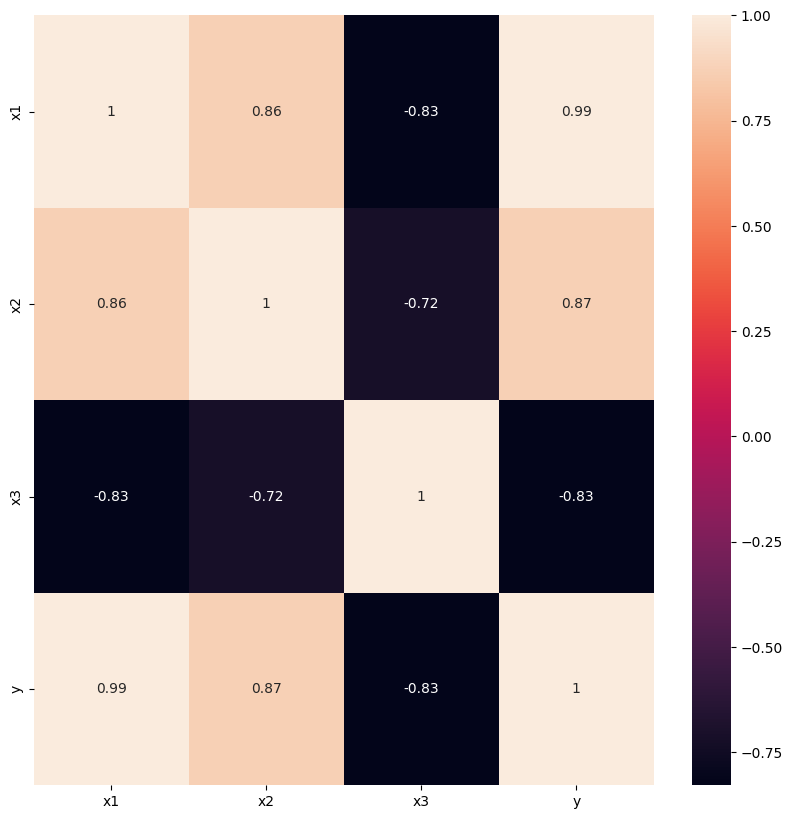

In [9]:
#Matriz de correlação numérica
plt.figure(figsize=(10,10))
sns.heatmap(dados_total.corr(), annot=True)
#plt.savefig(figs_path + 'corr_nume_all.png', bbox_inches='tight', dpi=1600)
plt.show()

In [10]:
sns.pairplot(dados_total, diag_kind='hist')
plt.show()

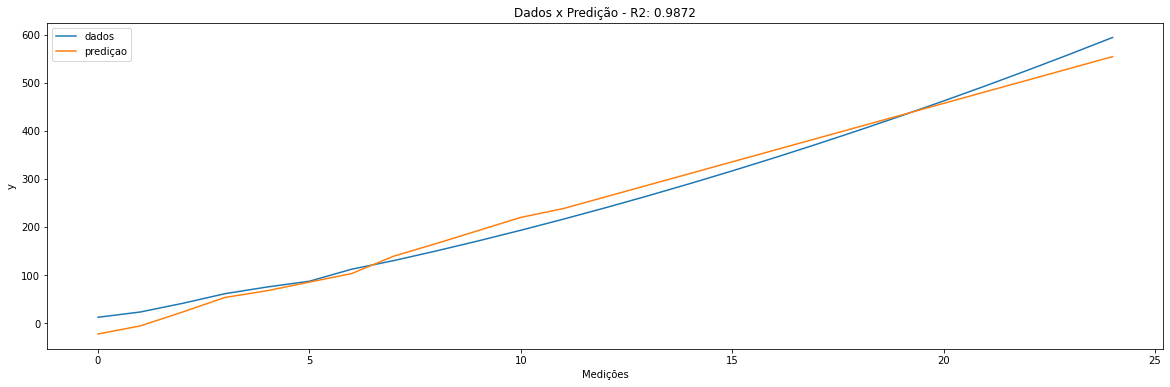

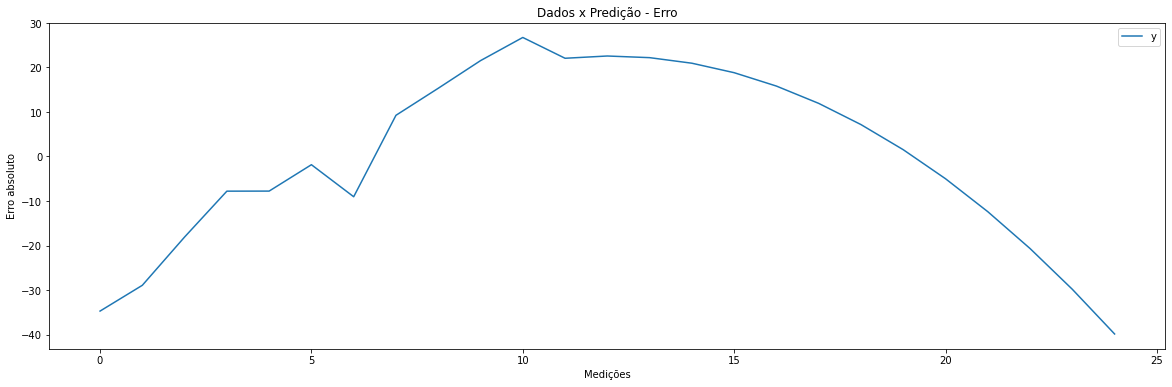

In [ ]:
regTotal = MultiVarLinearRegression(dados_total, ["y"])
regTotal.setup()
regTotal.solve()
resultsTotal = regTotal.plot_train_results()

In [ ]:
dados_sem_x1 = dados_total.drop(["x1"], axis=1)
dados_sem_x1

,x2,x3,y
0,5.000000,6.000000,12.000000
1,3.000000,6.000000,23.000000
2,6.000000,9.000000,41.000000
3,8.000000,8.000000,61.000000
4,4.000000,5.000000,75.000000
5,2.000000,4.000000,87.000000
6,4.000000,14.000000,112.000000
7,5.000000,5.000000,130.000000
8,6.000000,5.000000,150.000000
9,7.000000,4.000000,171.000000


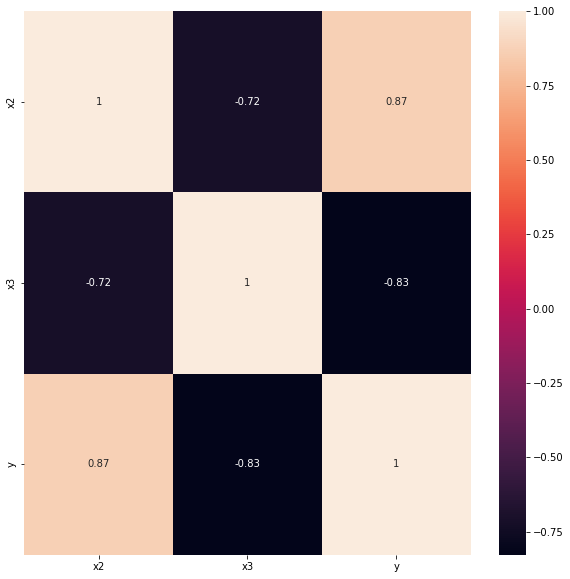

In [ ]:
#Matriz de correlação numérica
plt.figure(figsize=(10,10))
sns.heatmap(dados_sem_x1.corr(), annot=True)
#plt.savefig(figs_path + 'corr_nume_all.png', bbox_inches='tight', dpi=1600)
plt.show()

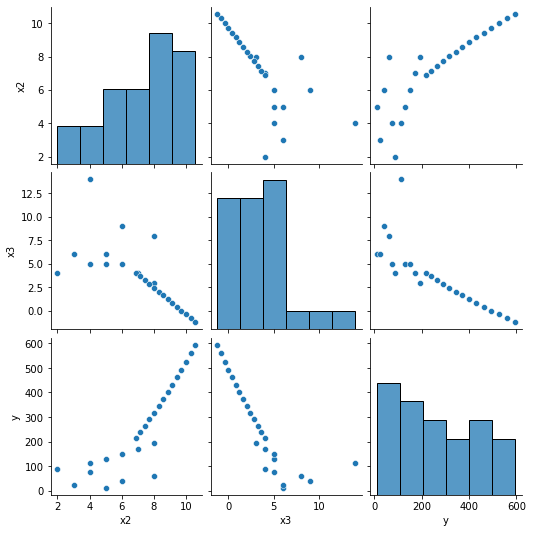

In [ ]:
sns.pairplot(dados_sem_x1)
plt.show()

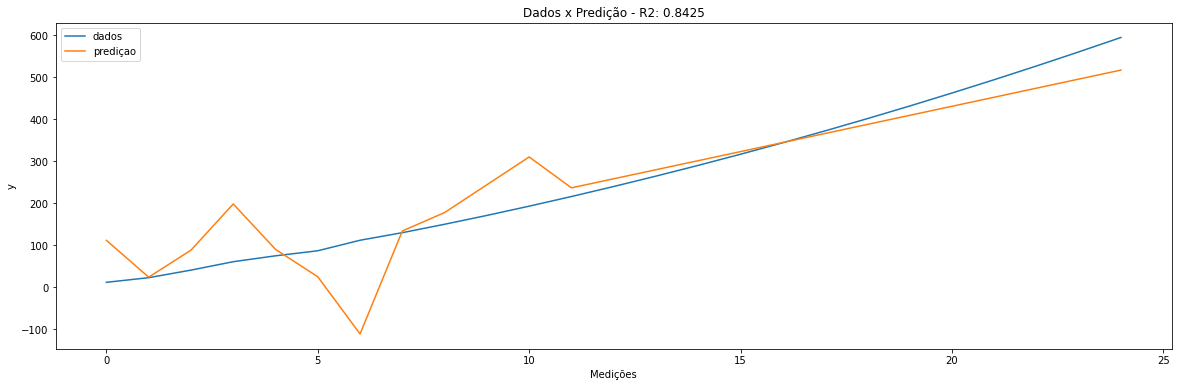

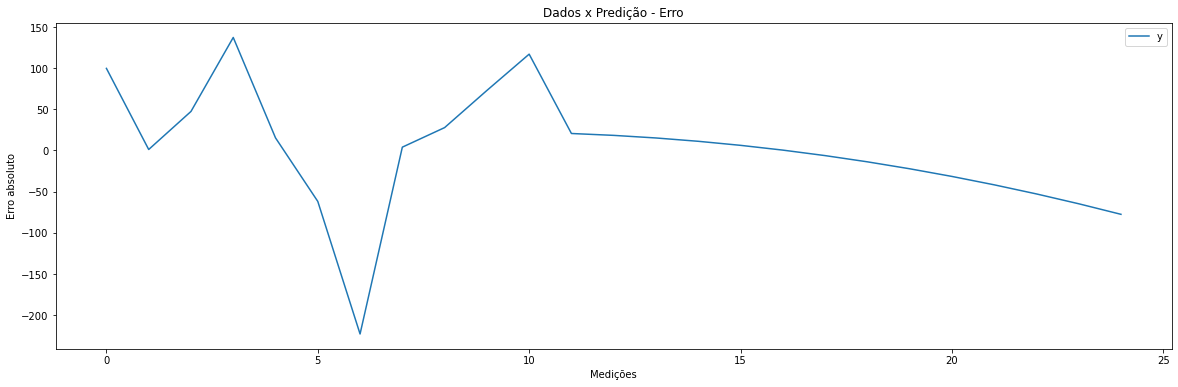

In [ ]:
regSemX1 = MultiVarLinearRegression(dados_sem_x1, ["y"])
regSemX1.setup()
regSemX1.solve()
resultsSemX1 = regSemX1.plot_train_results()

In [ ]:
dados_autoreg = dados_total.drop(["x1"], axis=1)
dados_autoreg['autoreg'] = dados_autoreg['y'].shift(2, axis=0)
dados_autoreg.dropna(axis=0, inplace=True)
dados_autoreg

,x2,x3,y,autoreg
2,6.000000,9.000000,41.000000,12.000000
3,8.000000,8.000000,61.000000,23.000000
4,4.000000,5.000000,75.000000,41.000000
5,2.000000,4.000000,87.000000,61.000000
6,4.000000,14.000000,112.000000,75.000000
7,5.000000,5.000000,130.000000,87.000000
8,6.000000,5.000000,150.000000,112.000000
9,7.000000,4.000000,171.000000,130.000000
10,8.000000,3.000000,193.000000,150.000000
11,6.866667,4.066667,215.933333,171.000000


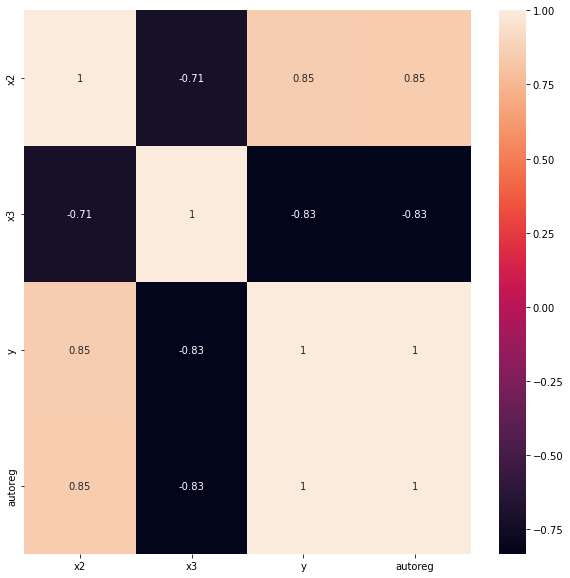

In [ ]:
#Matriz de correlação numérica
plt.figure(figsize=(10,10))
sns.heatmap(dados_autoreg.corr(), annot=True)
#plt.savefig(figs_path + 'corr_nume_all.png', bbox_inches='tight', dpi=1600)
plt.show()

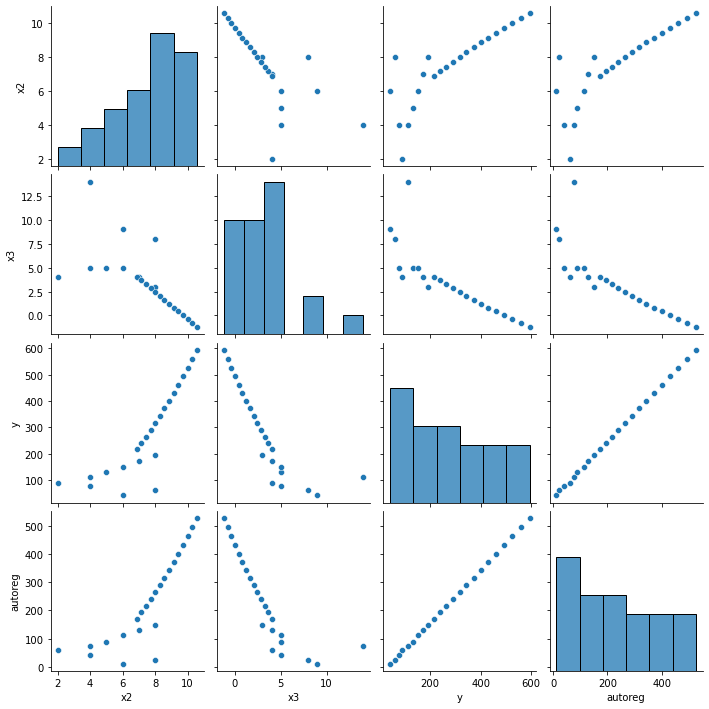

In [ ]:
sns.pairplot(dados_autoreg)
plt.show()

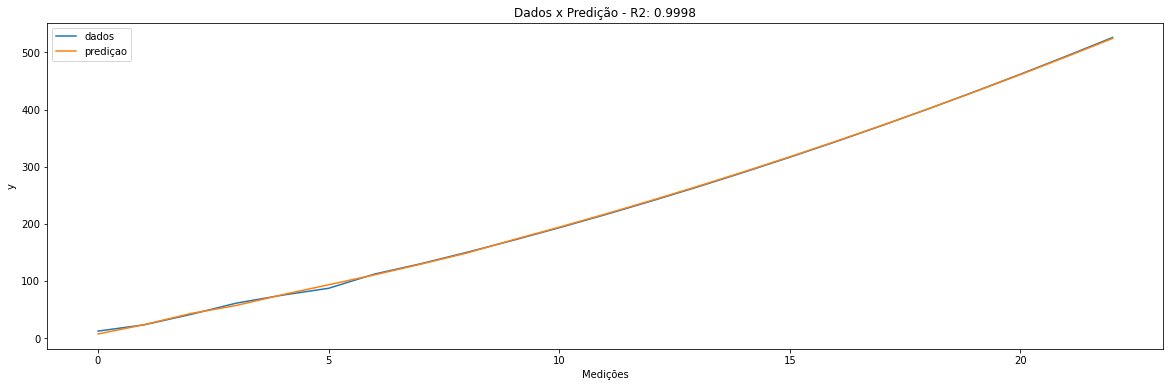

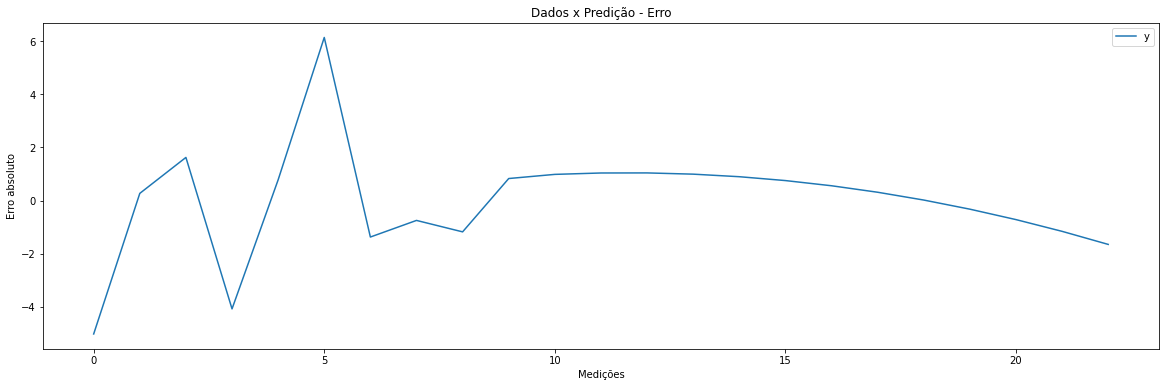

In [ ]:
regAutoReg = MultiVarLinearRegression(dados_autoreg, ["y"])
regAutoReg.setup()
regAutoReg.solve()
resultsAutoReg = regAutoReg.plot_train_results()

In [ ]:
dados_autoreg_doido = dados_total.drop(["x1"], axis=1)
dados_autoreg_doido['autoreg'] = 0.8*dados_autoreg['y'].shift(2, axis=0) - 0.5*dados_autoreg['y'].shift(4, axis=0) + 0.08*dados_autoreg['y'].shift(6, axis=0) - 0.05*dados_autoreg['y'].shift(8, axis=0)
dados_autoreg_doido.dropna(axis=0, inplace=True)
dados_autoreg_doido

,x2,x3,y,autoreg
10,8.000000,3.000000,193.000000,67.950000
11,6.866667,4.066667,215.933333,75.710000
12,7.151515,3.660606,239.745454,84.610000
13,7.436364,3.254545,264.436364,93.296667
14,7.721212,2.848485,290.006061,101.696364
15,8.006061,2.442424,316.454545,110.762424
16,8.290909,2.036364,343.781818,120.072121
17,8.575758,1.630303,371.987879,129.670121
18,8.860606,1.224242,401.072727,139.552061
19,9.145455,0.818182,431.036364,149.721273


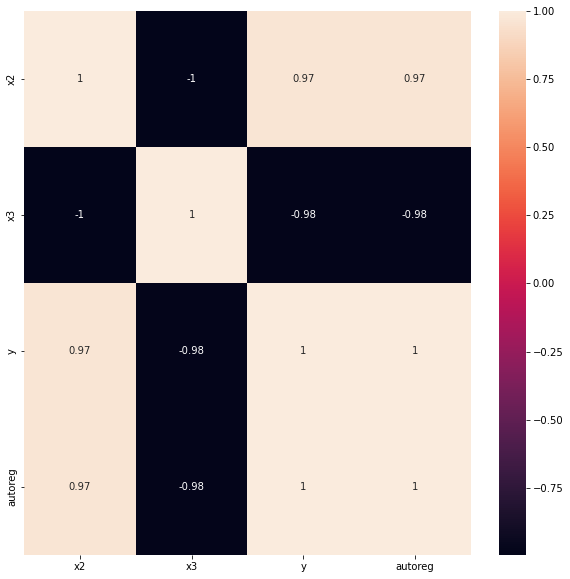

In [ ]:
#Matriz de correlação numérica
plt.figure(figsize=(10,10))
sns.heatmap(dados_autoreg_doido.corr(), annot=True)
#plt.savefig(figs_path + 'corr_nume_all.png', bbox_inches='tight', dpi=1600)
plt.show()

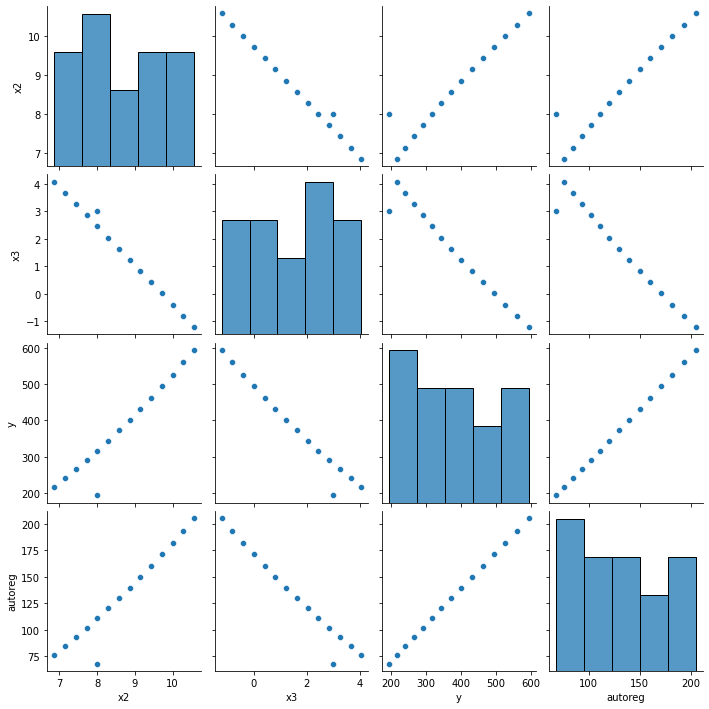

In [ ]:
sns.pairplot(dados_autoreg_doido)
plt.show()

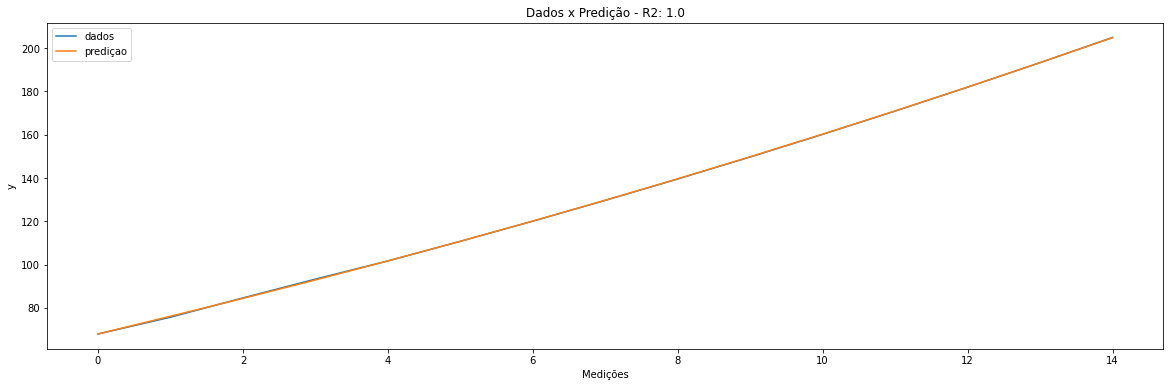

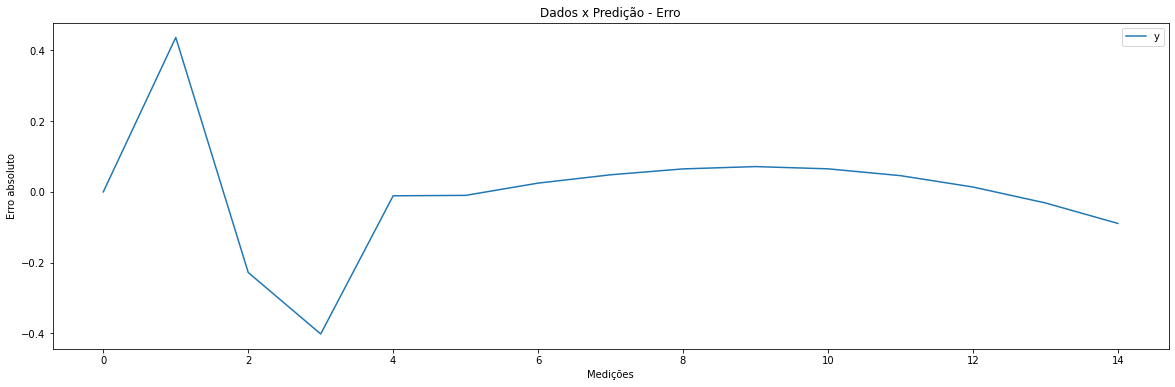

In [ ]:
regAutoRegDoido = MultiVarLinearRegression(dados_autoreg_doido, ["y"])
regAutoRegDoido.setup()
regAutoRegDoido.solve()
resultsDoido = regAutoRegDoido.plot_train_results()

In [ ]:
dados_autoreg_menos = dados_total.drop(["x1"], axis=1)
dados_autoreg_menos['autoreg'] = dados_autoreg['y'].shift(8, axis=0)
dados_autoreg_menos.dropna(axis=0, inplace=True)
dados_autoreg_menos

,x2,x3,y,autoreg
10,8.000000,3.000000,193.000000,41.000000
11,6.866667,4.066667,215.933333,61.000000
12,7.151515,3.660606,239.745454,75.000000
13,7.436364,3.254545,264.436364,87.000000
14,7.721212,2.848485,290.006061,112.000000
15,8.006061,2.442424,316.454545,130.000000
16,8.290909,2.036364,343.781818,150.000000
17,8.575758,1.630303,371.987879,171.000000
18,8.860606,1.224242,401.072727,193.000000
19,9.145455,0.818182,431.036364,215.933333


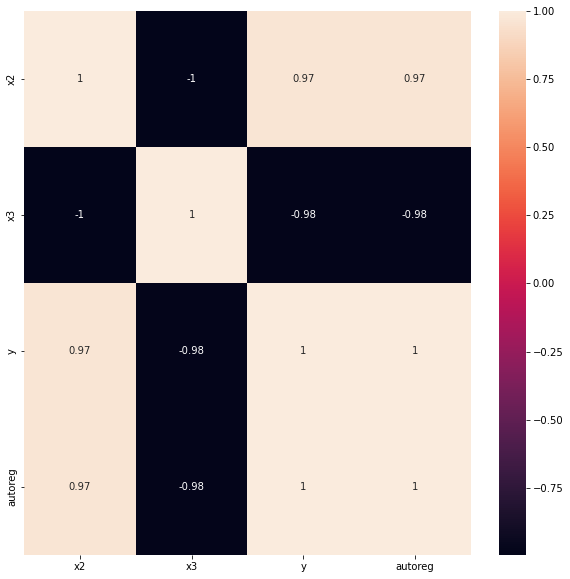

In [ ]:
#Matriz de correlação numérica
plt.figure(figsize=(10,10))
sns.heatmap(dados_autoreg_menos.corr(), annot=True)
#plt.savefig(figs_path + 'corr_nume_all.png', bbox_inches='tight', dpi=1600)
plt.show()

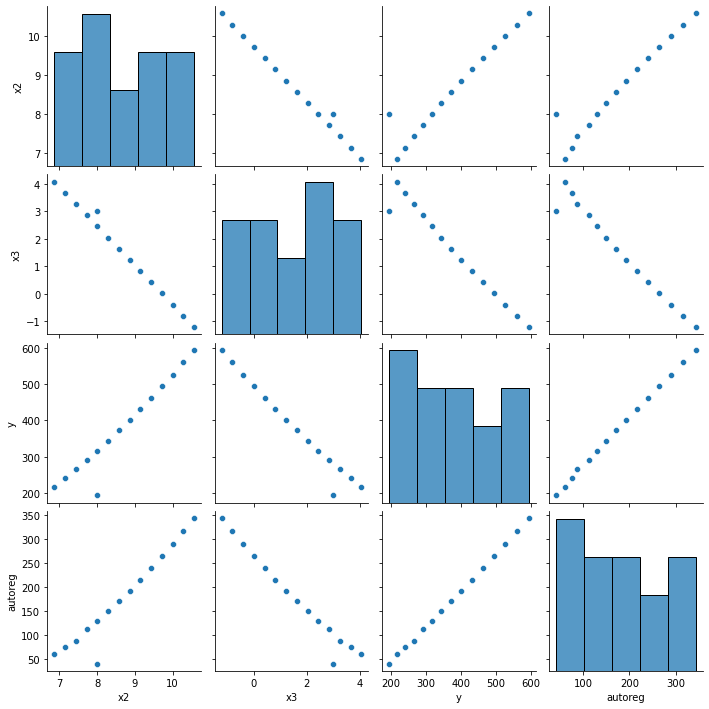

In [ ]:
sns.pairplot(dados_autoreg_menos)
plt.show()

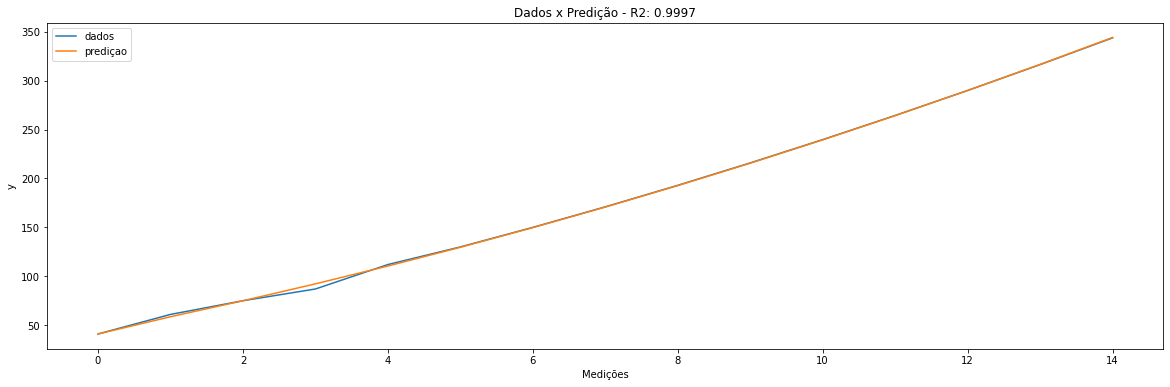

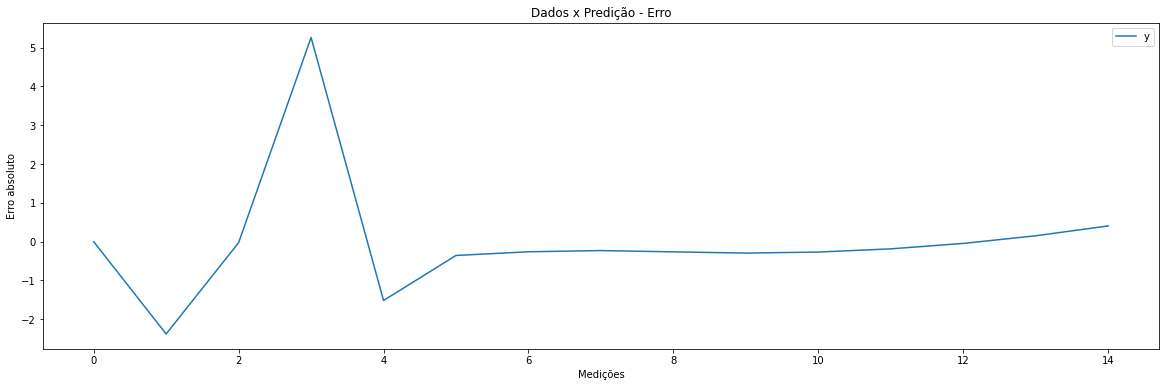

In [ ]:
regAutoRegMenos = MultiVarLinearRegression(dados_autoreg_menos, ["y"])
regAutoRegMenos.setup()
regAutoRegMenos.solve()
resultsMenos = regAutoRegMenos.plot_train_results()